In [1]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl
import paste
import scanpy as sc
import anndata
from sklearn.decomposition import NMF
import scanorama
import scipy

style.use('seaborn-dark')
mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14) 

In [2]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

## Read in Data

In [3]:
def load_breast_layer(path):
    X = pd.read_csv(path, delimiter = '\t', index_col= 0)
    coor = []
    for c in X.index:
        coor.append([float(x) for x in c.split('x')])
    adata = anndata.AnnData(X = X)
    adata.obsm['spatial'] = np.array(coor)
    return adata

In [4]:
layer1_path = "../breast_cancer_data/Layer1_BC_count_matrix-1.tsv"
layer2_path = "../breast_cancer_data/Layer2_BC_count_matrix-1.tsv"
layer3_path = "../breast_cancer_data/Layer3_BC_count_matrix-1.tsv"
layer4_path = "../breast_cancer_data/Layer4_BC_count_matrix-1.tsv"

In [5]:
adata_layer_1 = load_breast_layer(layer1_path)
adata_layer_2 = load_breast_layer(layer2_path)
adata_layer_3 = load_breast_layer(layer3_path)
adata_layer_4 = load_breast_layer(layer4_path)

## Define Simulation functions

### Simulate Spatial Noise

Takes a layer, rotates by angle. Next, we map all coordinates to closest integer coordinates.

This removes some points as two points who share the same closest integer pair will map to same coordinate.

In [6]:
def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 40
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

### Simulate Gene Expression

In [8]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X)
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

### Define Simulation Accuracy Metric

Since we know the rotation for the simulated layer, we know the exact mapping and thus can calculate % of spots correctly aligned.

In [9]:
def getSimulationAccuracy(adata_layer, adata_layer_sim, mapping, alpha):
    l = adata_layer.copy()
    siml = adata_layer_sim.copy()
    G = paste.pairwise_align(l, siml, alpha= alpha)
    s = 0
    for i in range(len(mapping)):
        s += G[mapping[i]][i]
    return s

## Create a Simulation varying Pseudocounts

### Define one iteration of a simulation

Given an initial layer, we simulate a new layer by perturbing spatial and gene expression information. Then, we run pairwise alignment and report the % of spots correctly mapped since we know the true mapping.

In [10]:
def simulate_once(adata_layer):
    # factor = list(range(1,11))
    pseudocounts = list(range(1,11))
    adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/3)
    # add the factor = 0 case
    max_accuracy = adata_layer_sim_spatial.shape[0]/adata_layer.shape[0]
    baseline = [max_accuracy]
    mixed_0_01 = [max_accuracy]
    mixed_0_1 = [max_accuracy]
    mixed_0_2 = [max_accuracy]
    mixed_0_5 = [max_accuracy]
    mixed_0_9 = [max_accuracy]
    
    
    s = getSimulationAccuracy(adata_layer, adata_layer_sim_spatial, mappings, 1)
    spatial = [s]
    
    # because we are varying pseudocounts, want to resimulate gene expression
    for p in pseudocounts:
        adata_layer_sim_both = adata_layer_sim_spatial.copy()
        adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_both, pc = p)
        b = getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0)
        
        baseline.append(b)
        mixed_0_01.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.01))
        mixed_0_1.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.1))
        mixed_0_2.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.2))
        mixed_0_5.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.5))
        mixed_0_9.append(getSimulationAccuracy(adata_layer, adata_layer_sim_both, mappings, 0.9))
        spatial.append(s)
    return baseline, mixed_0_01, mixed_0_1, mixed_0_2, mixed_0_5, mixed_0_9, spatial


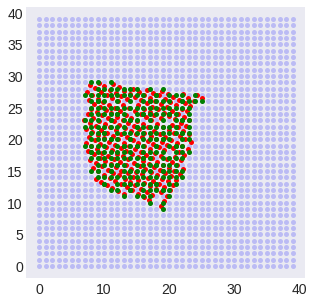

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

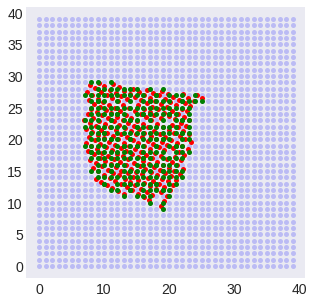

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

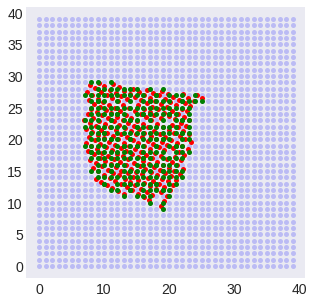

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

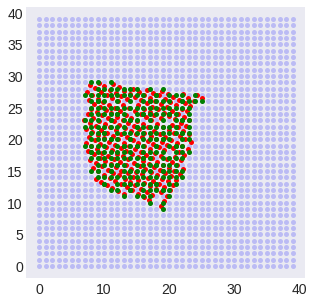

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

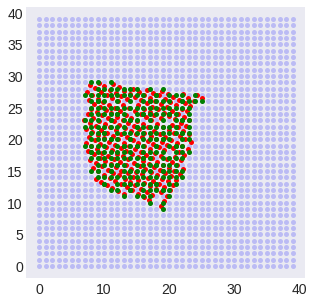

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

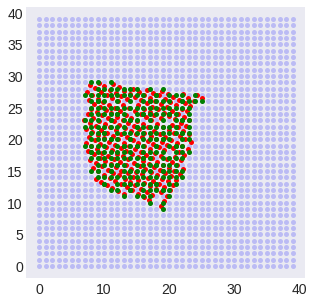

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

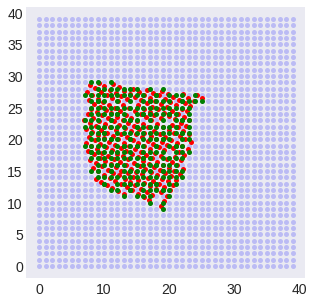

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

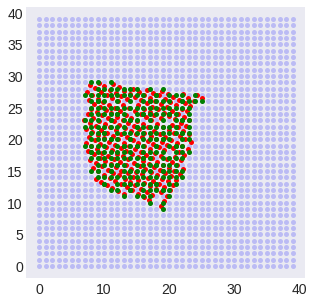

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

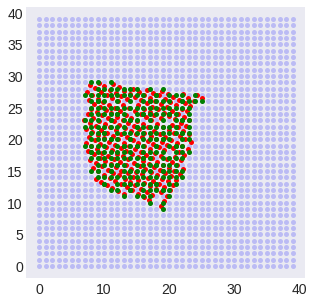

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

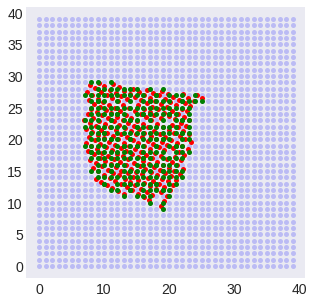

Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 14808 common genes.
Filtered all slices for common genes. There are 

In [11]:
baseline_all = []
mixed_0_01_all = []
mixed_0_1_all = []
mixed_0_2_all = []
mixed_0_5_all = []
mixed_0_9_all = []
spatial_all = []
for i in range(10):
    b, m_0_01,  m_0_1,  m_0_2,  m_0_5, m_0_9, s  = simulate_once(adata_layer_4)
    baseline_all.append(b)
    mixed_0_01_all.append(m_0_01)
    mixed_0_1_all.append(m_0_1)
    mixed_0_2_all.append(m_0_2)
    mixed_0_5_all.append(m_0_5)
    mixed_0_9_all.append(m_0_9)
    spatial_all.append(s)

In [12]:
print(np.array(mixed_0_01_all).mean(axis = 0))
print(np.array(mixed_0_1_all).mean(axis = 0))
print(np.array(mixed_0_2_all).mean(axis = 0))
print(np.array(mixed_0_5_all).mean(axis = 0))
print(np.array(mixed_0_9_all).mean(axis = 0))

[0.88167939 0.83032616 0.80994349 0.7878854  0.76664188 0.73150755
 0.70175804 0.68237335 0.63712204 0.61993655 0.58910479]
[0.88167939 0.81923763 0.80102277 0.7912065  0.78249232 0.77694557
 0.76535475 0.76580417 0.75734278 0.75191335 0.74847989]
[0.88167939 0.79742738 0.78126797 0.76732593 0.76046892 0.75498992
 0.74785863 0.74483989 0.74341892 0.74169062 0.73767886]
[0.88167939 0.74879383 0.74062159 0.73711212 0.73326063 0.72932983
 0.72637553 0.72679026 0.72446053 0.71991507 0.71999603]
[0.88167939 0.70763689 0.70322197 0.7014094  0.70050395 0.70048908
 0.70062457 0.70031394 0.70012227 0.69995043 0.70019001]


In [20]:
# pd.DataFrame(baseline_all).to_csv('./results/pairwise_sim/slice4/baseline.csv')
# pd.DataFrame(mixed_0_01_all).to_csv('./results/pairwise_sim/slice4/mixed_0.01.csv')
# pd.DataFrame(mixed_0_1_all).to_csv('./results/pairwise_sim/slice4/mixed_0.1.csv')
# pd.DataFrame(mixed_0_2_all).to_csv('./results/pairwise_sim/slice4/mixed_0.2.csv')
# pd.DataFrame(mixed_0_5_all).to_csv('./results/pairwise_sim/slice4/mixed_0.5.csv')
# pd.DataFrame(mixed_0_9_all).to_csv('./results/pairwise_sim/slice4/mixed_0.9.csv')
# pd.DataFrame(spatial_all).to_csv('./results/pairwise_sim/slice4/spatial.csv')

### Scanorama Simulation

Given an initial layer, we simulate a new layer by perturbing spatial and gene expression information. Next, we run Scanorama on the simulated layer. Finally, we run basic optimal transport between gene expression matrices of the true layer and Scanorama integrated layer and calculate % of spots correctly mapped.

In [80]:
import ot
import scanorama

def EDM(A, B):
    p1 = np.sum(A**2, axis = 1)[:, np.newaxis]
    p2 = np.sum(B**2, axis = 1)
    p3 = -2 * np.dot(A, B.T)
    return np.sqrt(p1+p2+p3)

def scanorama_pairwise_sim(adata_layer, p):
    adata_layer_sim_spatial, mappings = simulate_spatial(adata_layer, math.pi/3)
    adata_layer_sim_both = simulate_gene_exp(adata_layer_sim_spatial, pc = p)
    layers = [adata_layer.copy(), adata_layer_sim_both]

    datasets = []
    genes_list = []
    for l in layers:
        datasets.append(l.X)
        genes_list.append(list(l.var.index))

    integrated, corrected, genes = scanorama.correct(datasets, genes_list, return_dimred=True)
    D = EDM(integrated[0],integrated[1])
    a = np.ones((integrated[0].shape[0],)) / integrated[0].shape[0]
    b = np.ones((integrated[1].shape[0],)) / integrated[1].shape[0]  # uniform distribution on samples
    G = ot.emd(a, b, D)
    s = 0
    for i in range(len(mappings)):
        s += G[mappings[i]][i]
    return s

Iteration: 0


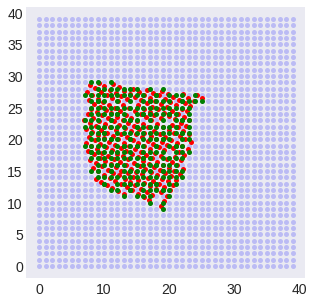

Found 14808 genes among all datasets
[[0.       0.995671]
 [0.       0.      ]]
Processing datasets (0, 1)


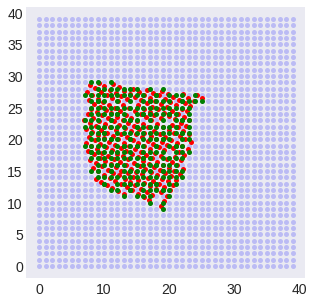

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


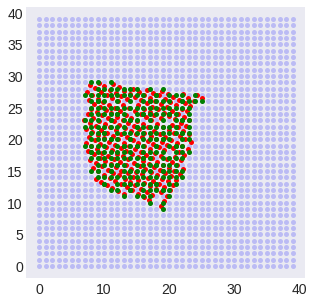

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


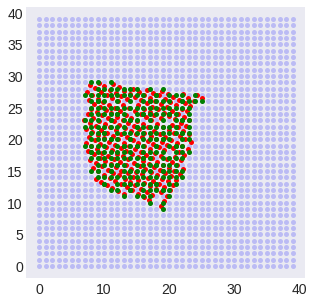

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


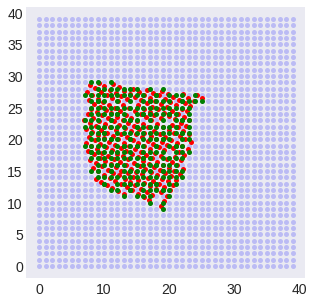

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


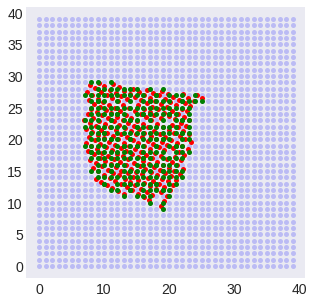

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


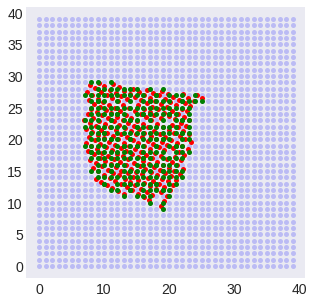

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


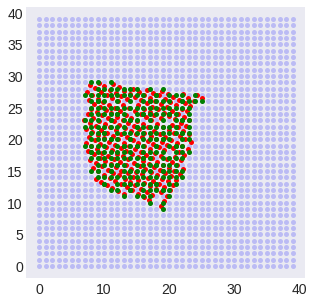

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


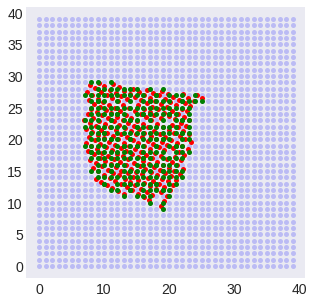

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


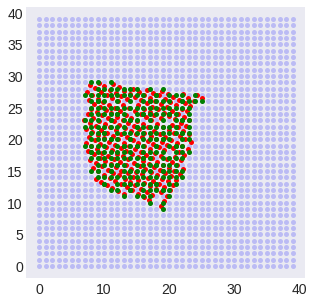

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


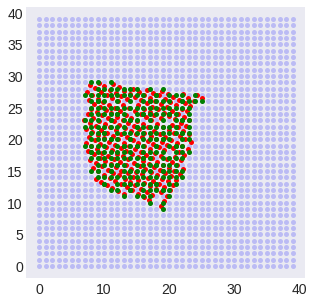

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 1


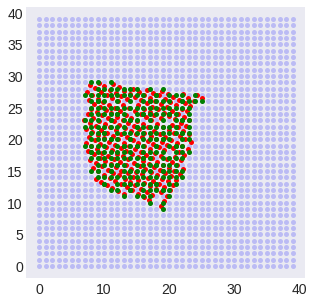

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


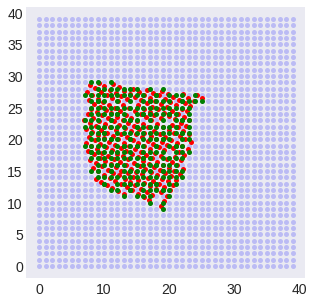

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


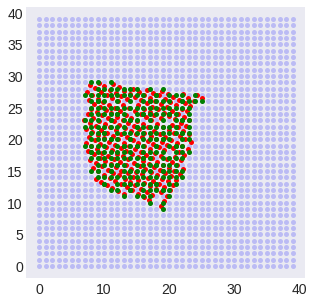

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


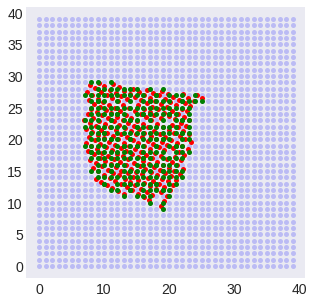

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


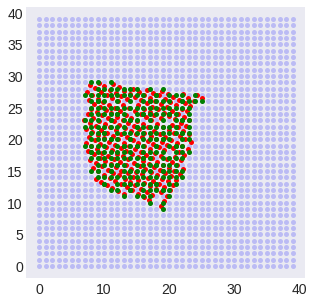

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


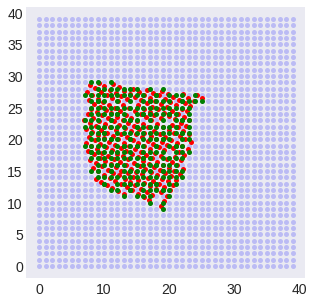

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


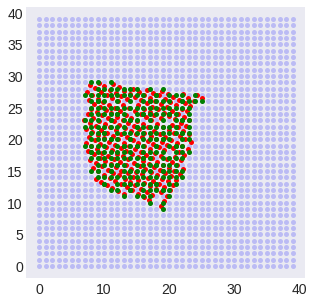

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


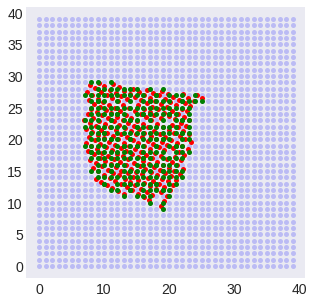

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


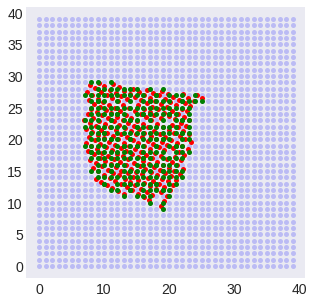

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


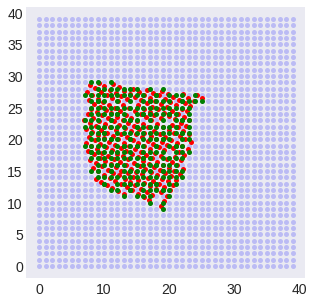

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


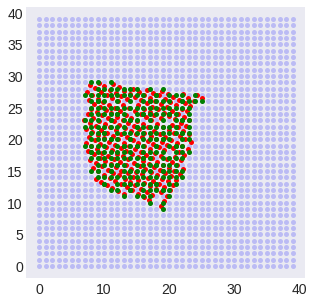

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 2


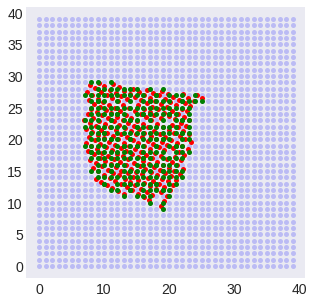

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


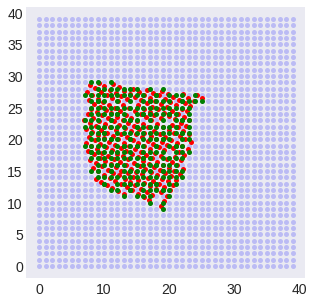

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


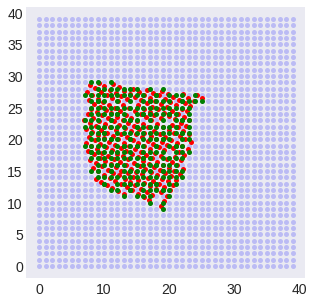

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


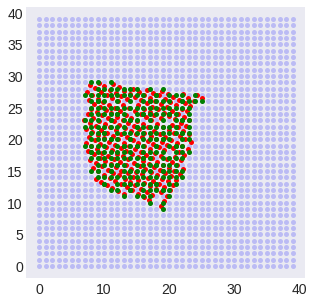

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


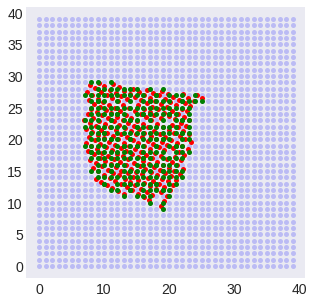

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


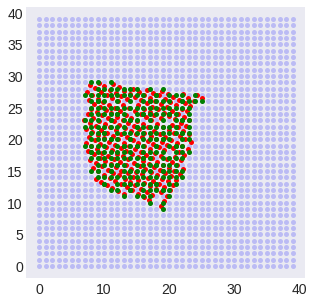

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


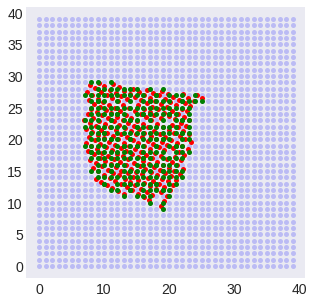

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


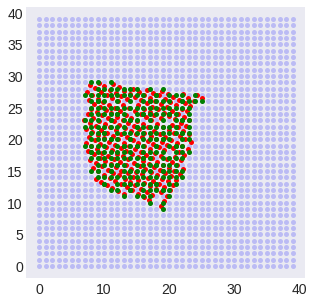

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


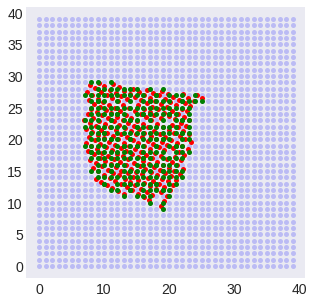

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


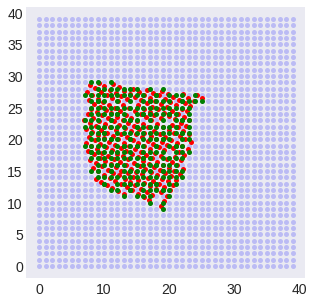

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


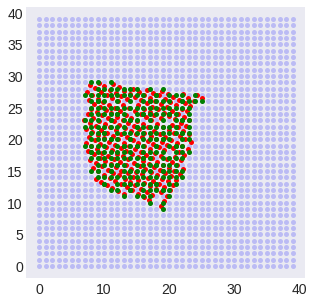

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 3


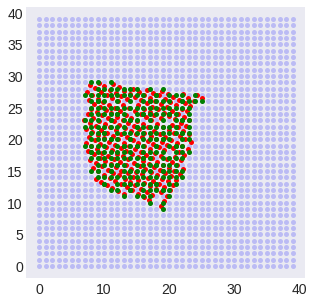

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


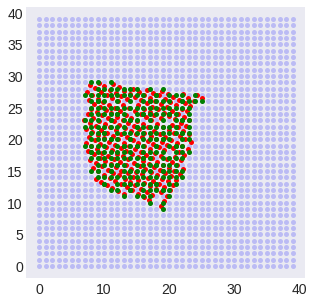

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


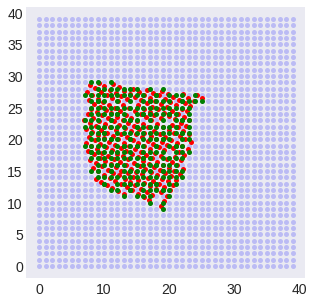

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


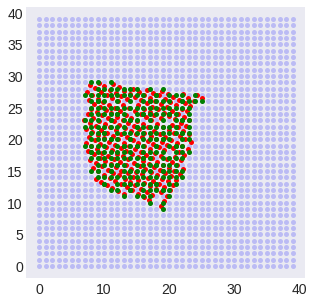

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


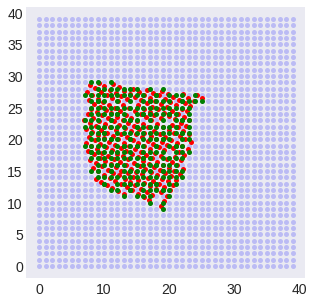

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


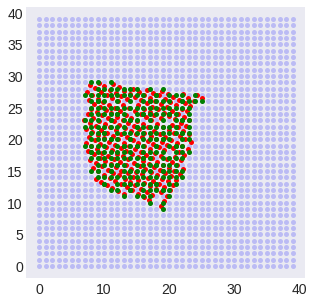

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


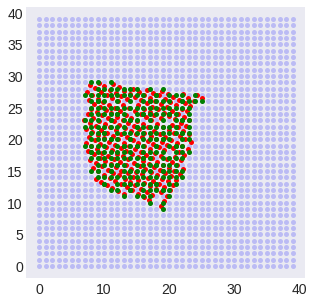

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


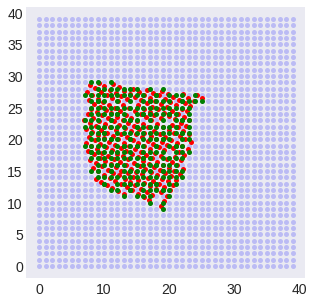

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


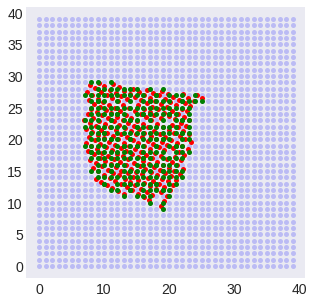

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


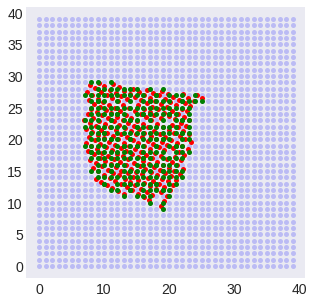

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


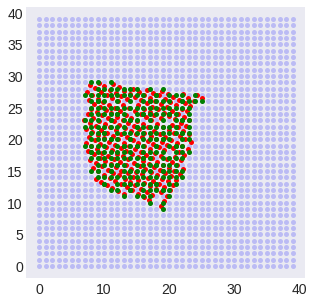

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 4


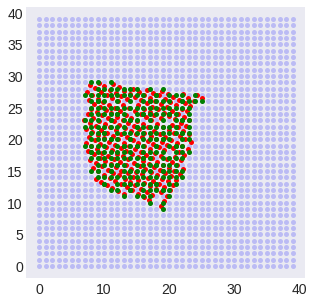

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


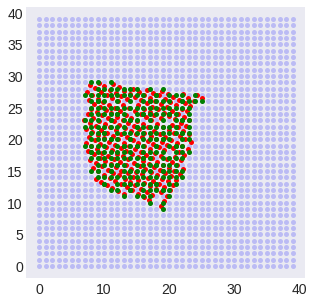

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


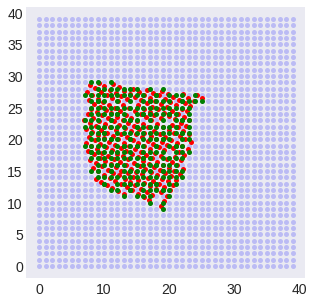

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


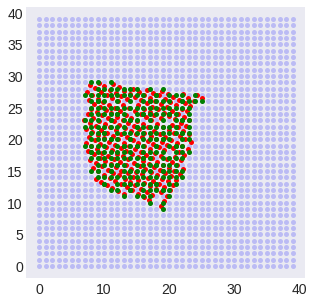

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


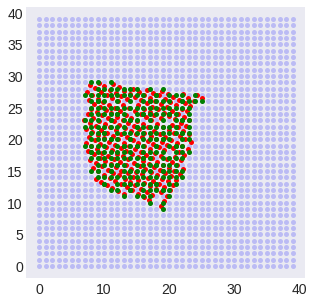

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


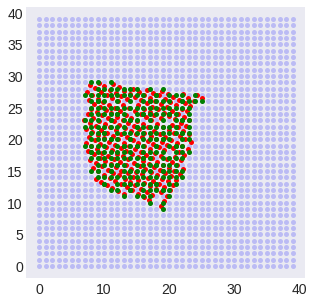

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


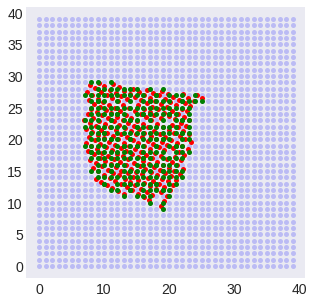

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


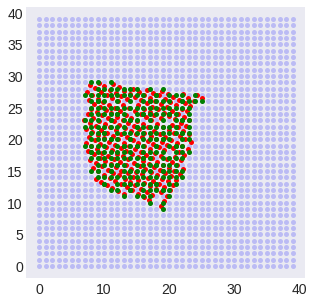

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


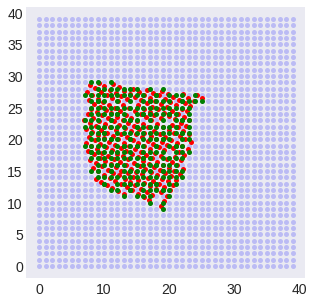

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


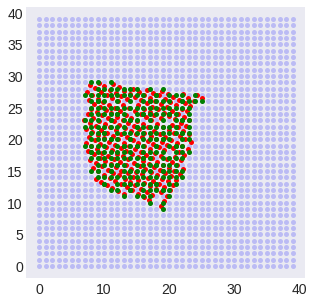

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


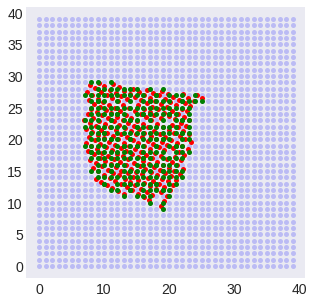

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 5


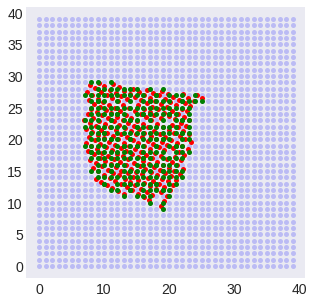

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


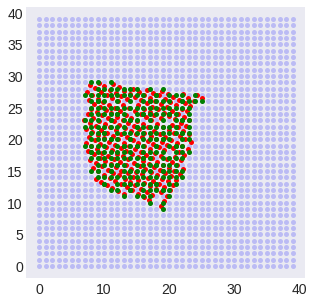

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


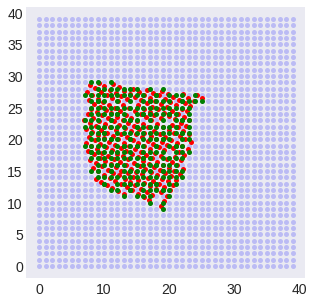

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


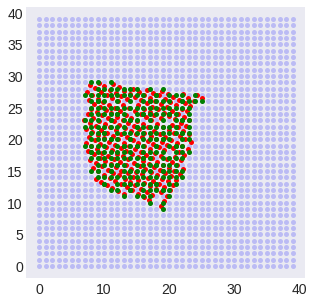

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


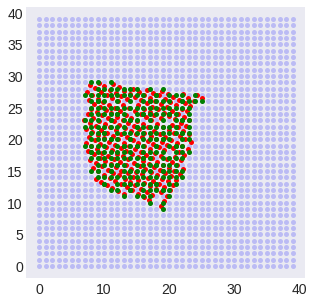

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


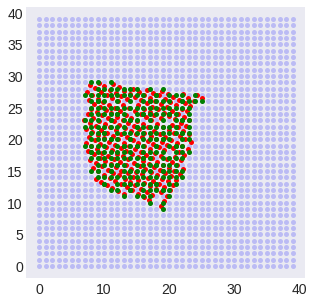

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


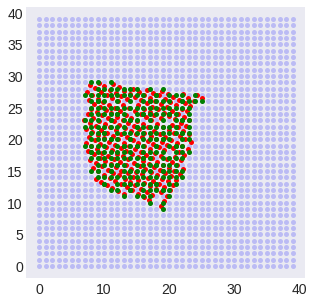

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


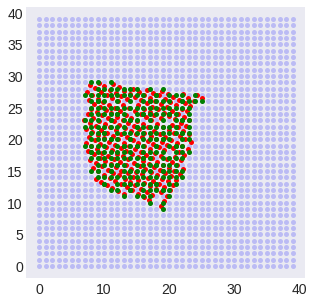

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


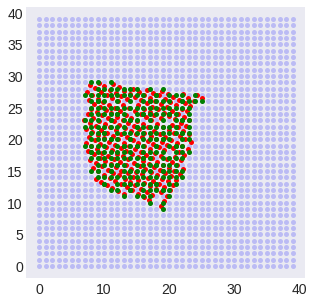

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


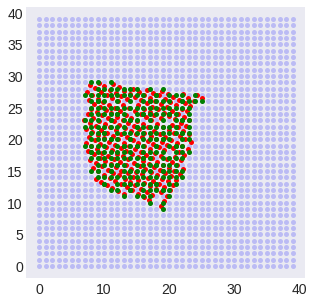

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


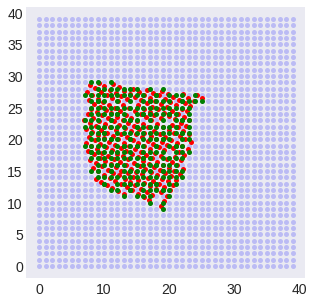

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 6


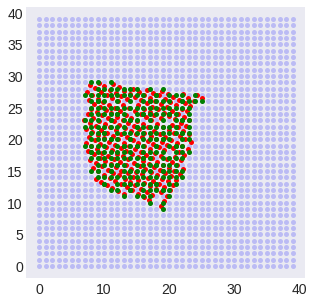

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


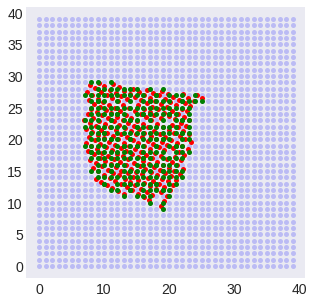

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


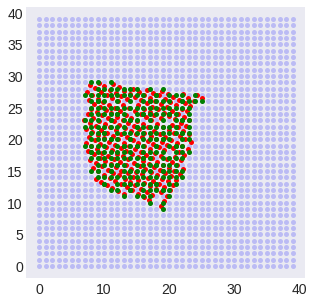

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


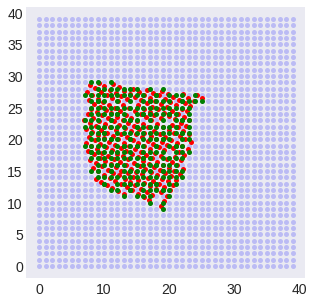

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


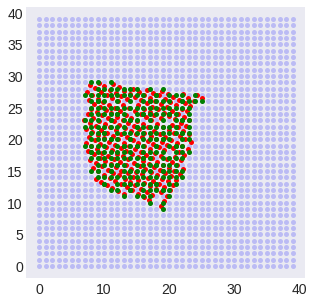

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


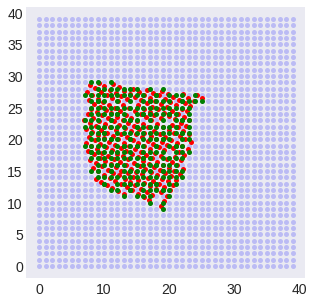

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


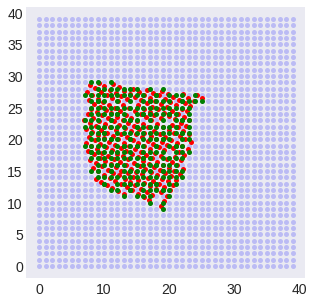

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


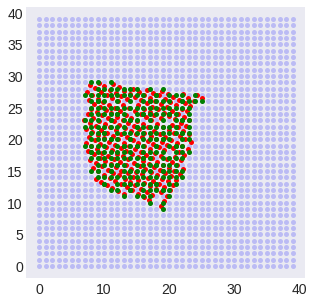

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


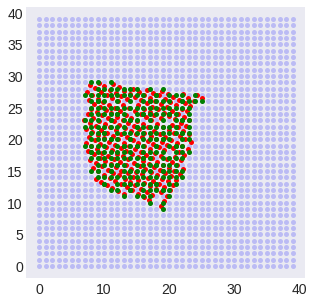

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


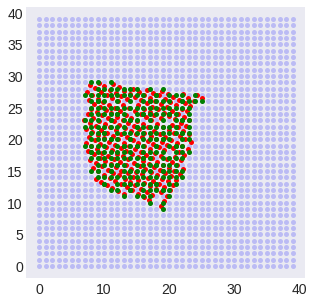

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


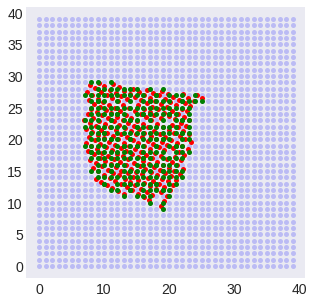

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 7


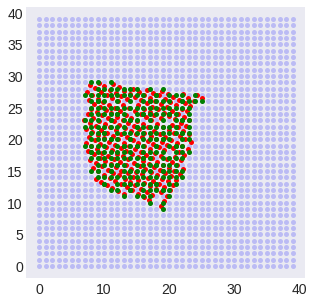

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


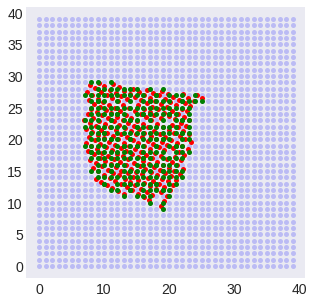

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


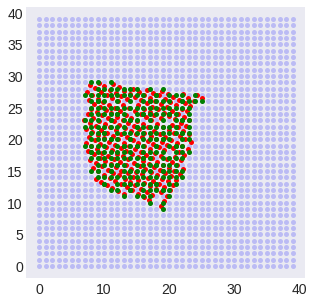

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


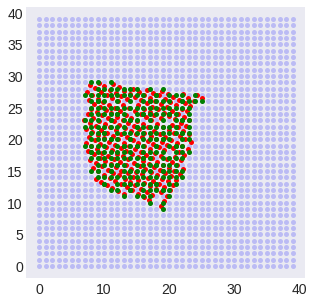

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


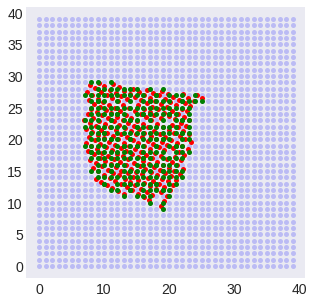

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


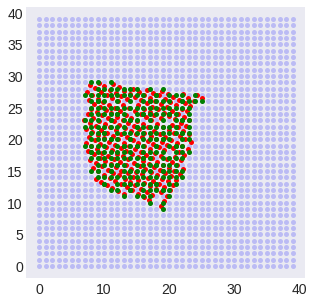

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


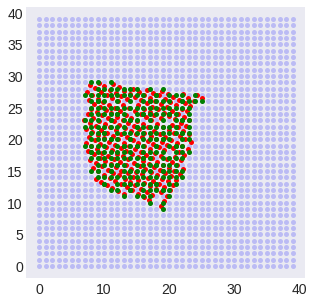

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


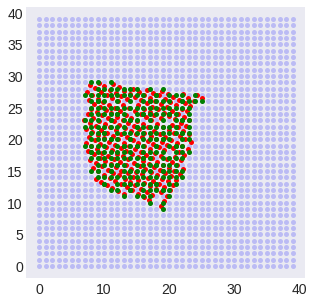

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


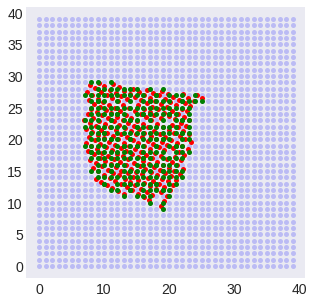

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


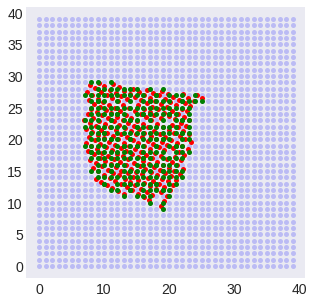

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


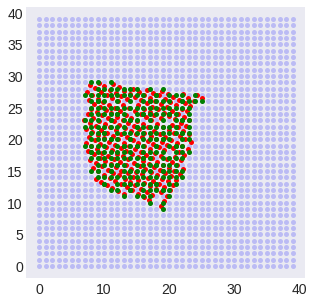

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 8


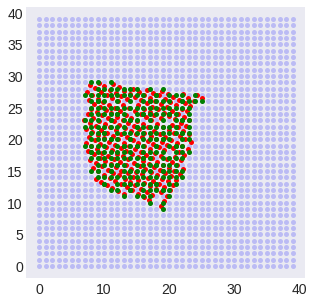

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


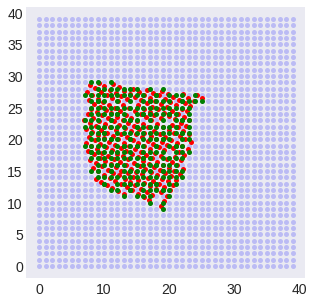

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


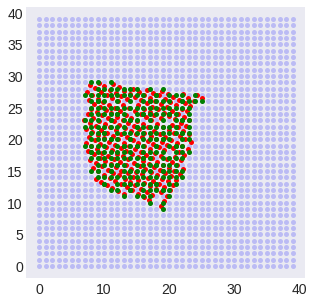

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


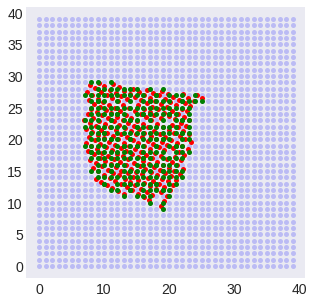

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


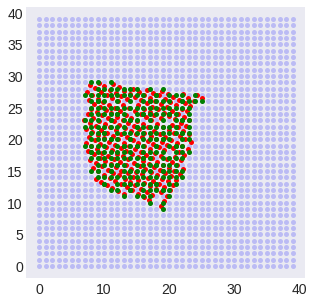

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


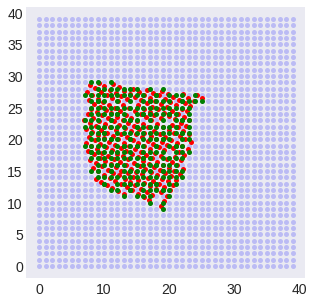

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


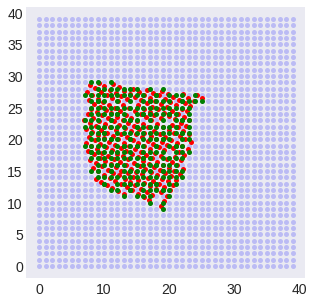

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


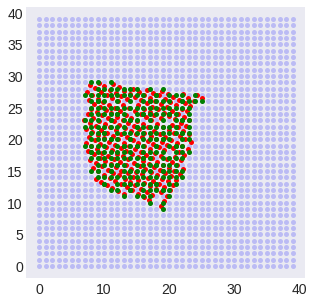

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


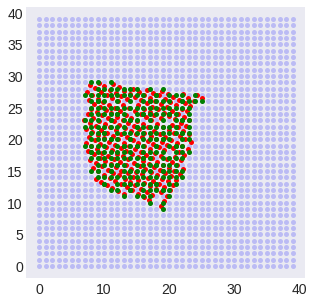

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


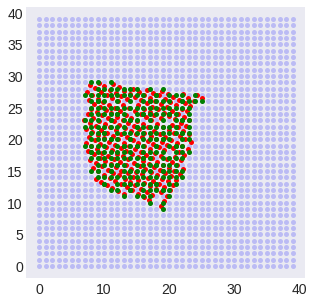

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


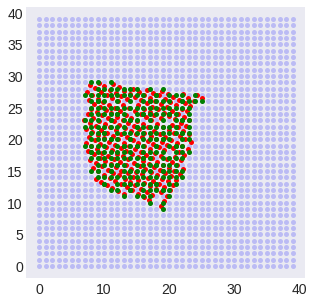

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)
Iteration: 9


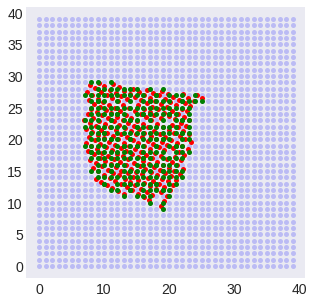

Found 14808 genes among all datasets
[[0.         0.98473282]
 [0.         0.        ]]
Processing datasets (0, 1)


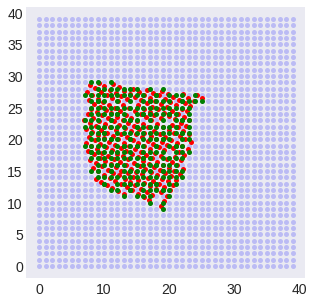

Found 14808 genes among all datasets
[[0.         0.85114504]
 [0.         0.        ]]
Processing datasets (0, 1)


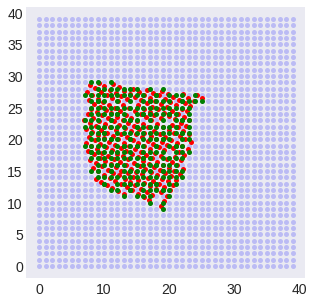

Found 14808 genes among all datasets
[[0.         0.58008658]
 [0.         0.        ]]
Processing datasets (0, 1)


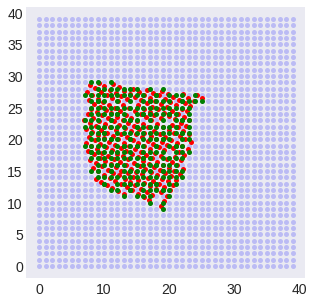

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


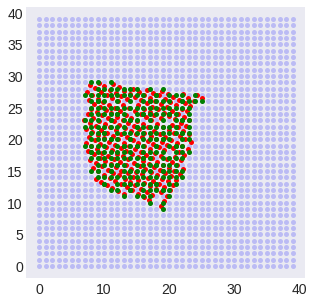

Found 14808 genes among all datasets
[[0.         0.51145038]
 [0.         0.        ]]
Processing datasets (0, 1)


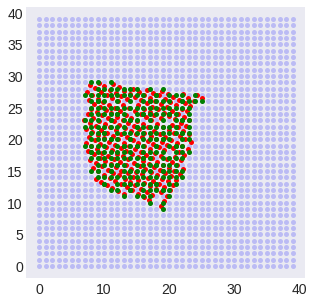

Found 14808 genes among all datasets
[[0.         0.54545455]
 [0.         0.        ]]
Processing datasets (0, 1)


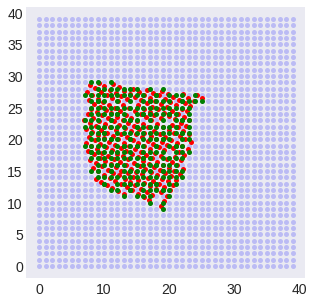

Found 14808 genes among all datasets
[[0.         0.58441558]
 [0.         0.        ]]
Processing datasets (0, 1)


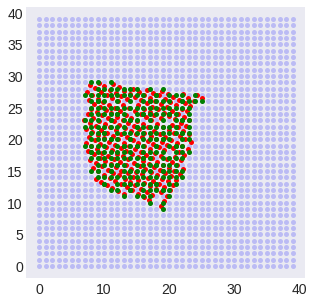

Found 14808 genes among all datasets
[[0.         0.54112554]
 [0.         0.        ]]
Processing datasets (0, 1)


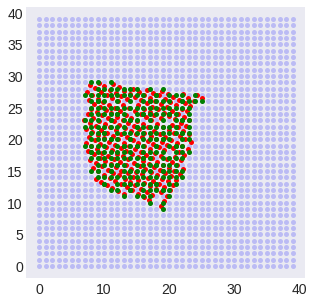

Found 14808 genes among all datasets
[[0.         0.54978355]
 [0.         0.        ]]
Processing datasets (0, 1)


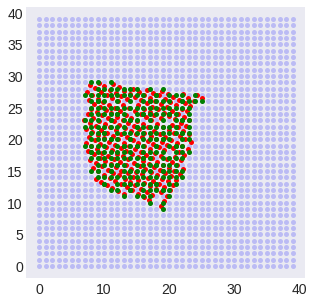

Found 14808 genes among all datasets
[[0.         0.51515152]
 [0.         0.        ]]
Processing datasets (0, 1)


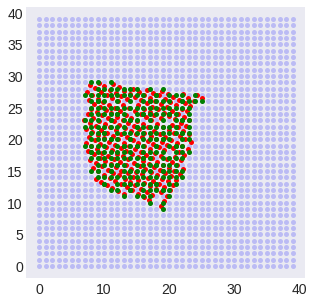

Found 14808 genes among all datasets
[[0.         0.46183206]
 [0.         0.        ]]
Processing datasets (0, 1)


In [92]:
runs = []
for i in range(10):
    print("Iteration: " + str(i))
    pseudocounts = list(range(11))
    results = []
    for p in pseudocounts:
        results.append(scanorama_pairwise_sim(adata_layer_4, p))
    runs.append(results)

In [93]:
# pd.DataFrame(runs).to_csv('./results/pairwise_sim/slice4/scanorama.csv')

## Plot Results

In [13]:
filenames = ['baseline.csv','mixed_0.01.csv','mixed_0.1.csv',
             'mixed_0.2.csv','mixed_0.5.csv','mixed_0.9.csv','spatial.csv', 'scanorama.csv']
keys = [0, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 'scanorama']

mean = {}
sd = {}
for i in range(len(filenames)):
    mean[keys[i]] = []
    sd[keys[i]] = []   


for s in ['slice1', 'slice2', 'slice3', 'slice4']:
    for i in range(len(filenames)):
        path = './results/pairwise_sim/' + s + '/' + filenames[i]
        mean[keys[i]].append(pd.read_csv(path, index_col= 0).mean())
        sd[keys[i]].append(pd.read_csv(path, index_col= 0).std())



['Max Accuracy', 'α = 0.1 (Mixed)', 'α = 0 (Gene Exp Only)', 'α = 1 (Spatial Only)', 'Scanorama + OT', 'α = 0.01 (Mixed)', 'α = 0.2 (Mixed)', 'α = 0.5 (Mixed)', 'α = 0.9 (Mixed)']


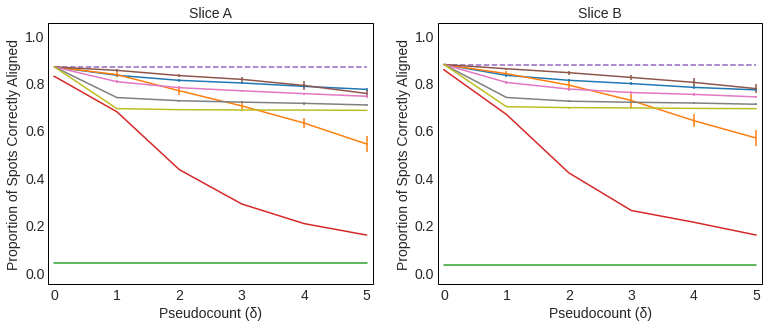

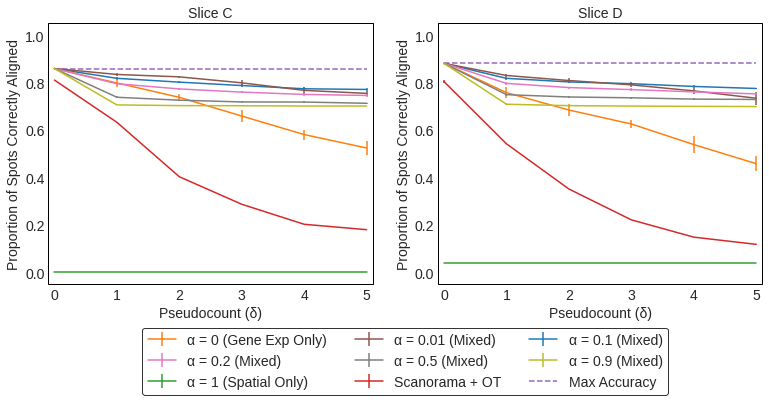

In [102]:
factor = list(range(11))

f, ax = plt.subplots(1,2, figsize=(12.8, 4.8))
f1, ax1 = plt.subplots(1,2, figsize=(12.8, 4.8))
# Setting the values for all axes.
plt.setp(ax, xlim=(-0.1,5.1), ylim=(-0.05,1.05))
x = np.arange(0, 6, 1).tolist()

title = dict(zip(range(4), ['A', 'B', 'C', 'D']))

for a, i in zip([ax[0], ax[1], ax1[0], ax1[1]], range(4)):
    a.errorbar(x, mean[0.1][i][0:6], yerr = sd[0.1][i][0:6], label = "α = 0.1 (Mixed)")
    a.errorbar(x, mean[0][i][0:6], yerr = sd[0][i][0:6], label= "α = 0 (Gene Exp Only)")
    a.errorbar(x, mean[1][i][0:6], yerr = sd[1][i][0:6], label = "α = 1 (Spatial Only)")
    a.errorbar(x, mean['scanorama'][i][0:6], yerr = sd['scanorama'][i][0:6], label = "Scanorama + OT")

    m1 = 6*[mean[0.1][i][0]]
    a.plot(factor[0:6], m1, '--', label = "Max Accuracy")

    a.errorbar(x, mean[0.01][i][0:6], yerr = sd[0.01][i][0:6], label = "α = 0.01 (Mixed)")
    a.errorbar(x, mean[0.2][i][0:6], yerr = sd[0.2][i][0:6], label = "α = 0.2 (Mixed)")
    a.errorbar(x, mean[0.5][i][0:6], yerr = sd[0.5][i][0:6], label = "α = 0.5 (Mixed)")
    a.errorbar(x, mean[0.9][i][0:6], yerr = sd[0.9][i][0:6], label = "α = 0.9 (Mixed)")
    a.set_title('Slice ' + title[i], fontsize = 14)

for i in range(2):
    ax[i].set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
    ax[i].set_facecolor('white')
    ax[i].patch.set_edgecolor('black')
    ax[i].patch.set_linewidth('1')  
    ax[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax[i].set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
    ax[i].set_xticks(np.arange(min(x), max(x)+1, 1.0))
    
    ax1[i].set(xlim=(-0.1,5.1), ylim=(-0.05,1.05))
    ax1[i].set_facecolor('white')
    ax1[i].patch.set_edgecolor('black')
    ax1[i].patch.set_linewidth('1')  
    ax1[i].set_xlabel('Pseudocount (δ)', fontsize = 14)
    ax1[i].set_ylabel('Proportion of Spots Correctly Aligned', fontsize = 14)
    ax1[i].set_xticks(np.arange(min(x), max(x)+1, 1.0))

h, l = ax1[1].get_legend_handles_labels()
handles = [h[2], h[6], h[3], h[5], h[7], h[4], h[1], h[8], h[0]] 
labels = [l[2], l[6], l[3], l[5], l[7], l[4], l[1], l[8], l[0]] 
print(l)
ax1[1].legend(handles, labels, loc = 'lower center', bbox_to_anchor=(-0.1, -0.45), frameon=True, edgecolor='black', facecolor='white', ncol=3, fontsize=14)
plt.show()
# f.savefig('breast_sim_A1_v2.pdf', dpi = 300, bbox_inches = "tight")
# f1.savefig('breast_sim_B1_v2.pdf', dpi = 300, bbox_inches = "tight")